In [1]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.0.0


# Animation

In [2]:
from matplotlib import tri as mtri
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy
import h5py 

In [3]:
!nvidia-smi

Sun Dec 15 10:45:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:45:00.0 Off |                    0 |
| N/A   29C    P0             61W /  400W |       1MiB /  81920MiB |      0%   E. Process |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## LSTM animation

In [4]:
def make_animation_lstm(gs_loader, pred_loader, evl_loader, rmse_var, path, name, args, 
                        skip = 2, save_anim = True, plot_variables = False,
                   traj_num = 0):
    
    if (args.var_type == 'sat'):
        ylabel = 'Saturation RMSE'
        legend_name = 'Gas saturation' 
        scale = 1.0
    elif (args.var_type == 'p'):
        ylabel = 'Pressure RRMSE'
        legend_name = 'Pressure (MPa)'
        scale = 1e6 # change to mpa

    gs = gs_loader[0]
    pred = pred_loader[0]
    evl = evl_loader[0]
    '''
    input gs is a dataloader and each entry contains attributes of many timesteps.

    '''
    print('Generating {} fields...'.format(name))
    #fig, axes = plt.subplots(1, 3, figsize=(36, 10))
    # currently only support outputting one mesh at a time
    num_steps = gs.y.shape[1] # for a single trajectory
    num_frames = num_steps // skip
    print(num_steps)
    plt.ion() 

    bb_min = gs.y[:, :].min()/scale # gas saturation
    bb_max = gs.y[:, :].max()/scale # use max and min velocity of gs dataset at the first step for both 
                                  # gs and prediction plots
    
    bb_min_evl = evl.y[:, :].min()/scale  # gas saturation
    bb_max_evl = evl.y[:, :].max()/scale  # use max and min velocity of gs dataset at the first step for both 
                                  # gs and prediction plots
    traj = traj_num                             
    if (plot_variables):
        name += '_rmse'
        fig = plt.figure(figsize=[36, 20])
        axes = [plt.subplot(2, 3, 1), 
            plt.subplot(2, 3, 2),
            plt.subplot(2, 3, 3),
            plt.subplot(2, 1, 2)] # add a subplot to show the evolution of saturation RMSE
    else:
        fig = plt.figure(figsize=[36, 10])
        axes = [plt.subplot(1, 3, 1), 
            plt.subplot(1, 3, 2),
            plt.subplot(1, 3, 3)]

    def single_ax_plot(count, ax, step):

        if ( count > 2 ):

            ax.set_xlabel('Iteration', fontsize = '20' )
            ax.set_ylabel( ylabel,  fontsize = '20')
            ax.plot(np.arange(0, step + 1), rmse_var[:step + 1], marker= 'o', c= 'k', linewidth=1)
            return False
            
        ax.cla()
        ax.set_aspect('equal')
        ax.set_axis_off()

        pos = gs.mesh_pos 

        if (count == 0):
            # ground truth
            velocity = gs.y[:, step]/scale
            title = 'Ground truth:'
        elif (count == 1):
            velocity = pred.y[:, step]/scale
            title = 'Prediction:'
        else: 
            velocity = evl.y[:, step]/scale
            title = 'Relative Error:'

        #triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
        triang = mtri.Triangulation(pos[:, 0], pos[:, 1])
        if (count <= 1):
            # absolute values
            mesh_plot = ax.tripcolor(triang, velocity, vmin= bb_min, vmax=bb_max,  shading='flat', cmap= 'viridis')
            ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
        else:
            # error: (pred - gs)/gs
            mesh_plot = ax.tripcolor(triang, velocity, vmin= bb_min_evl, vmax=bb_max_evl, shading='flat', cmap= 'viridis')
            ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
            #ax.triplot(triang, lw=0.5, color='0.5')

        ax.set_title('{} Trajectory {} Step {}'.format(title, traj, step), fontsize = '20')
        return mesh_plot
    # Frame 0
    count = 0 
    for ax in axes:
        mesh_plot = single_ax_plot(count, ax, 0)
        if ( mesh_plot == False):
            break
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        clb = fig.colorbar(mesh_plot, cax=cax, orientation='vertical')
        clb.ax.tick_params(labelsize=20) 
        clb.ax.set_title( legend_name,
                        fontdict = {'fontsize': 20})
        count += 1
    # the rest of frame
    def animate(num):
        step = (num*skip) % num_steps
        count = 0
        for ax in axes:
            mesh_plot = single_ax_plot(count, ax, step)
            if ( mesh_plot == False):
                break

            cax.cla()
            clb = fig.colorbar(mesh_plot, cax=cax, orientation='vertical')
            clb.ax.tick_params(labelsize=20) 

            clb.ax.set_title(legend_name,
                            fontdict = {'fontsize': 20})
            count += 1

        return fig

    # Save animation for visualization
    if not os.path.exists(path):
        os.makedirs(path)
    
    if (save_anim):
        gs_anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=2000)
        writergif = animation.PillowWriter(fps=10) 
        anim_path = os.path.join(path, '{}_anim.gif'.format(name))
        gs_anim.save( anim_path, writer=writergif, dpi = 50)
        plt.show(block=True)
    else:
        pass


## Onestep animation

In [5]:
def make_animation_onestep(gs, pred, evl, rmse_var, path, name , args,
                           skip = 2, save_anim = True, plot_variables = False, traj_num = 0):
    '''
    input gs is a dataloader and each entry contains attributes of many timesteps.

    '''
    print('Generating {} fields...'.format(name))
    #fig, axes = plt.subplots(1, 3, figsize=(36, 10))
    if (args.var_type == 'sat'):
        ylabel = 'Saturation RMSE'
        legend_name = 'Gas saturation' 
        scale = 1.0
    elif (args.var_type == 'p'):
        ylabel = 'Pressure RRMSE'
        legend_name = 'Pressure (MPa)'
        scale = 1e6 # change to mpa

    num_steps = len(gs) # for a single trajectory
    num_frames = num_steps // skip
    print(num_steps)
    plt.ion() 

    bb_min = gs[-1].y[:, 0].min()/ scale # gas saturation
    bb_max = gs[-1].y[:, 0].max()/ scale # use max and min velocity of gs dataset at the first step for both 
                                  # gs and prediction plots
    bb_min_evl = evl[0].y[:, 0].min()/scale  # gas saturation
    bb_max_evl = evl[0].y[:, 0].max()/scale  # use max and min velocity of gs dataset at the first step for both 
                                  # gs and prediction plots
    traj = traj_num                             
    if (plot_variables):
        name += '_rmse'
        fig = plt.figure(figsize=[36, 20])
        axes = [plt.subplot(2, 3, 1), 
            plt.subplot(2, 3, 2),
            plt.subplot(2, 3, 3),
            plt.subplot(2, 1, 2)] # add a subplot to show the evolution of saturation RMSE
    else:
        fig = plt.figure(figsize=[36, 10])
        axes = [plt.subplot(1, 3, 1), 
            plt.subplot(1, 3, 2),
            plt.subplot(1, 3, 3)]

    def single_ax_plot(count, ax, step):

        if ( count > 2 ):
            ax.set_xlabel('Iteration', fontsize = '20' )
            ax.set_ylabel(ylabel,  fontsize = '20')
            ax.plot(np.arange(0, step + 1), rmse_var[:step + 1], marker= 'o', c= 'k', linewidth=1)
            return False
            
        ax.cla()
        ax.set_aspect('equal')
        ax.set_axis_off()

        pos = gs[step].mesh_pos 

        if (count == 0):
            # ground truth
            velocity = gs[step].y[:, 0]/ scale
            title = 'Ground truth:'
        elif (count == 1):
            velocity = pred[step].y[:, 0]/ scale
            title = 'Prediction:'
        else: 
            velocity = evl[step].y[:, 0]/scale
            title = 'Relative Error:'

        #triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
        triang = mtri.Triangulation(pos[:, 0], pos[:, 1])
        if (count <= 1):
            # absolute values
            mesh_plot = ax.tripcolor(triang, velocity, vmin= bb_min, vmax=bb_max,  shading='flat', cmap= 'viridis')
            ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
        else:
            # error: (pred - gs)/gs
            mesh_plot = ax.tripcolor(triang, velocity, vmin= bb_min_evl, vmax=bb_max_evl, shading='flat', cmap= 'viridis')
            ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
            #ax.triplot(triang, lw=0.5, color='0.5')

        ax.set_title('{} Trajectory {} Step {}'.format(title, traj, step), fontsize = '20')
        return mesh_plot
    # Frame 0
    count = 0 
    for ax in axes:
        mesh_plot = single_ax_plot(count, ax, 0)
        if ( mesh_plot == False):
            break
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        clb = fig.colorbar(mesh_plot, cax=cax, orientation='vertical')
        clb.ax.tick_params(labelsize=20) 
        clb.ax.set_title(legend_name ,
                        fontdict = {'fontsize': 20})
        count += 1
    # the rest of frame
    def animate(num):
        step = (num*skip) % num_steps
        count = 0
        for ax in axes:
            mesh_plot = single_ax_plot(count, ax, step)
            if ( mesh_plot == False):
                break

            cax.cla()
            clb = fig.colorbar(mesh_plot, cax=cax, orientation='vertical')
            clb.ax.tick_params(labelsize=20) 
            clb.ax.set_title(legend_name,
                            fontdict = {'fontsize': 20})
            count += 1

        return fig

    # Save animation for visualization
    if not os.path.exists(path):
        os.makedirs(path)
    
    if (save_anim):
        gs_anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=2000)
        writergif = animation.PillowWriter(fps=10) 
        anim_path = os.path.join(path, '{}_anim.gif'.format(name))
        gs_anim.save( anim_path, writer=writergif)
        plt.show(block=True)
    else:
        pass

# Visualization

In [6]:
def visualize(loader, best_model, file_dir, args, gif_name, stats_list, comp_args, sequntial = True,
              rolling_out = False,
              make_movie = True, plot_rmse = False,
              delta_t = 0.01, skip = 1, traj_num = 0 , save_vtk = False):

    gif_name = 'Mesh{}'.format(str(traj_num)) + '_' + gif_name
    best_model.eval()
    device = args.device
    rmse_var = []
    relative_err_var = []
    viz_data = {}
    gs_data = {}
    eval_data = {}
    viz_data_loader = copy.deepcopy(loader)
    gs_data_loader = copy.deepcopy(loader)
    eval_data_loader = copy.deepcopy(loader)

    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
            std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))
    
    if (save_vtk):
        if not os.path.isdir( args.vtk_dir ):
            os.mkdir(args.vtk_dir)

        file_name = os.path.join( args.vtk_dir, 'Mesh'+ str(traj_num) +'.h5')
        data_file = h5py.File(file_name, "w")
        sg_gs, sg_pred, sg_eval = [], [], []

    for data, viz_data, gs_data, eval_data, i in zip( loader, viz_data_loader,
                                                  gs_data_loader, eval_data_loader, range(len(loader))):    
        data=data.to(args.device) 
        viz_data = viz_data.to(args.device)

        tmp_data = copy.deepcopy(viz_data)
        gs_data = gs_data.to(args.device)
        
        with torch.no_grad():
            for num in range(args.rollout_num):
                # onestep only has 1 rollout 
                # sequential model has many rollouts, but only take in one mesh at one time
                if (sequntial):
                    if (num == 0):
                        h_0 = torch.zeros(data.x.shape[0], args.hidden_dim).to(device)
                        c_0 = torch.zeros(data.x.shape[0], args.hidden_dim).to(device)

                    pred, h_0, c_0 = best_model(tmp_data, mean_vec_x,std_vec_x,
                                                mean_vec_edge,std_vec_edge, h_0, c_0)
                else:
                    # one-step predictor
                    pred = best_model(tmp_data, mean_vec_x,std_vec_x,
                                                mean_vec_edge,std_vec_edge)
                
                tmp_data.x[:, 0] = stats.unnormalize( pred.squeeze(), mean_vec_y[0], std_vec_y[0] )
                if (args.rela_perm.lower() != 'none'):
                    #print('sg mean {}'.format(torch.mean(batch_tmp.x[:, 0])))
                    gs_rela_perm, _ = uti_func.calc_rela_perm(args, comp_args, tmp_data.x[:, 0], 1. - tmp_data.x[:, 0])  # calculate gs rela perm
                    #print(gs_rela_perm.shape)
                    #print(torch.mean(gs_rela_perm))
                    tmp_data.x[:, -1] = gs_rela_perm              # update cell-wise rela perm

                viz_data.y[:, num]= stats.unnormalize( pred.squeeze(), mean_vec_y[0], std_vec_y[0] )
                
                # gs_data - viz_data = error_data
                eval_data.y[:, num] = (viz_data.y[:, num] - data.y[:, num])
                if (args.var_type == 'sat'):
                    eps = 0.01
                    # sat relative difference 
                    rmse_var.append( torch.sqrt(torch.mean(eval_data.y[:, num]**2) ))  

                elif (args.var_type == 'p'):
                    eps = 0.0
                    # for pressure, we use rrmse (relative RMSE)
                    rmse_var.append( torch.sqrt(torch.mean(eval_data.y[:, num]**2))/ torch.mean(data.y[:, num]) ) # scaled by the average value of gs truth 
 
                relative_err_var.append(torch.mean(torch.abs(eval_data.y[:, num]/(data.y[:, num] + eps))))
                
                if (save_vtk):
                    sg_gs.append(data.y[:, num].numpy())
                    sg_pred.append(viz_data.y[:, num].numpy())
                    sg_eval.append(eval_data.y[:, num].numpy())

                # pred gives the learnt saturation changes between two timsteps  
              
            if (sequntial):
                del tmp_data
                del h_0
                del c_0
            #traj_num += 1

    if (save_vtk):
        data_file.create_dataset('sg_gs', data = np.array(sg_gs))
        data_file.create_dataset('sg_pred', data = np.array(sg_pred))
        data_file.create_dataset('sg_eval', data = np.array(sg_eval))
        data_file.create_dataset('sg_rmse', data = rmse_var)
        data_file.close()
        print('Finish writing {}'.format(file_name))

    if (make_movie):
        if (sequntial or rolling_out):
            # lstm 
            # one mesh; multiple ys
            make_animation_lstm(gs_data_loader, viz_data_loader, eval_data_loader, rmse_var, file_dir,
                          gif_name, args, skip, True, plot_rmse, traj_num)
        else:
            # one-step
            # multiple mesh; one y
            make_animation_onestep(gs_data_loader, viz_data_loader, eval_data_loader, rmse_var, file_dir,
                      gif_name,args, skip, True, plot_rmse, traj_num)

    return eval_data_loader, rmse_var, relative_err_var

# Setup plotting attributes

In [7]:
from matplotlib import rc
import seaborn as sns 
import matplotlib as mpl

# set the plot style
def set_style():
    #plt.rc("font", family="Times New Roman")
    rc('mathtext', default='regular')
    sns.set_style('ticks')
    sns.set(style="ticks", rc={'axes.linewidth': 3.0, 'font.family': "sans-serif"})    
    sns.set_context("paper",font_scale = 2.0, rc={"font.size":20,
                                                  "axes.titlesize":20,
                                                  "axes.labelsize":20,
                                                  "lines.linewidth": 2.5})
     
set_style()
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

## Setup dirs

In [10]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, 'datasets')
checkpoint_dir = os.path.join(root_dir, 'best_models')
postprocess_dir = os.path.join(root_dir, 'animations')
modelsummary_dir = os.path.join(root_dir, 'model_details')
vtk_dir = os.path.join(root_dir, 'vtk_files')
pd_dir = os.path.join(root_dir, 'pd_dir')
fig_dir = os.path.join(root_dir, 'fig_dir')

if not os.path.isdir( fig_dir ):
    os.mkdir(fig_dir)

In [11]:
checkpoint_dir

'/home/groups/tchelepi/ju1/02_dl_modeling/04_research_projects/01_gnn_flow/03_github_version/mgn_lstm/best_models'

# Utility functions

In [12]:
import stats
import mesh_model
import uti_func

## Read model and data name

In [15]:
def read_model_and_data( args):
    if (args.data_name == ''):
        args.data_name = 'mesh{}_data{}_var{}_model{}_totalTs{}_skip{}_multistep{}_{}edge_{}label_{}relPerm.pt'.format(
                                                                                                          args.data_type,
                                                                                                          args.hete_type,
                                                                                                          args.var_type,  
                                                                                                            args.model,
                                                                                                          args.total_ts, 
                                                                                                          args.skip, 
                                                                                                          args.step, 
                                                                                                          args.edge_type, 
                                                                                                          args.label_type, 
                                                                                                          args.rela_perm)
    else:
        print(f'Reading processed data {args.data_name}')

    if (args.model_name == ''):
        args.model_name= 'model'+ args.model+'_seed' + str(args.seed) +'_var'+ args.var_type + \
                  '_node_based' + str(args.node_based) + args.data_type + '_edge'+ args.edge_type + \
                '_relPerm' + args.rela_perm + \
                    '_skip'+ str(args.skip)  + '_roll_num' + str(args.rollout_num) +\
                   '_well_weight' + str(args.well_weight) +\
                   '_model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)
    else:
        print(f'Using pretrained weights {args.model_name}')

    return args.data_name, args.model_name

## Read input arguments and load model

In [16]:
def read_input_and_reload_model(args):
    
    #To ensure reproducibility the best we can, here we control the sources of
    #randomness by seeding the various random number generators used in this Colab
    #For more information, see: https://pytorch.org/docs/stable/notes/randomness.html

    torch.manual_seed(5)  #Torch
    random.seed(5)        #Python
    np.random.seed(5)     #NumPy

    # reading computational arguments
    for c_args in [
            {
              'is_initial': True,
             'coord_sg':'',
             'coord_sw':'',
             'rel_sg':'',
             'rel_sw':'',
             },
        ]:
            comp_args = objectview(c_args)
            
    # read the name of model and input data 
    data_name, model_name = read_model_and_data(args) 
    file_path=os.path.join(dataset_dir, data_name)
    print('Reading {}'.format(data_name))
    dataset = torch.load(file_path)
    stats_list = stats.get_stats(dataset, args, comp_args)
    print(stats_list)
    
    # load model. 
    args.device = torch.device('cpu') # animation function cannot work with data on GPU
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 1 # the dynamic variables have the shape of 1 (saturation)

    #mgn_model_path = os.path.join( checkpoint_dir, 'model_nl10_bs16_hd10_ep1000_wd0.0005_lr0.001_shuff_True_tr45_te10.pt')

    PATH = os.path.join( checkpoint_dir, '{}.pt'.format(model_name))
    args.anim_name = model_name
    #args.anim_name= 'New_MS5_LSTM_MGN_FLoss_data_PEBI_roll_num_11f_weight0.9_w_weight_0.8_LSTM_k_9_normTrue_model_nl9_bs10_hd128_ep500_wd0.0005_lr0.001_shuff_False_tr900_te100'
    model = mesh_model.MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                                args).to(args.device)
    #mgn_model.load_state_dict(torch.load(mgn_model_path, map_location=args.device))
    
    if (args.use_rnn):
        model = mesh_model.TransferTempoMGN( model, args.hidden_dim, num_classes,
                                    args).to(args.device)

    model.load_state_dict(torch.load(PATH, map_location=args.device))
    
    return args, model, stats_list, file_path, comp_args


# MGN-LSTM

## Hyperparameter

In [17]:
weighted_list = np.ones(11)* 1.0
weighted_list

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
import random

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

# Input arguements
for args in [
        {'model': 'LSTM',  
         'use_rnn': True,
         'loss_type': 'rmse',
         'device':'cpu', # for visualization

         # data name related
         'data_name': '',
         'hete_type': 'hete',
         'edge_type': 'dist',
         'data_type': 'PEBI', 
         'var_type':'sat',
         'rollout_num':11,
         'step': 1,
         'total_ts': 11, 
         'label_type':'y',
         'skip': 5,
         'node_based':'',
         'rela_perm': 'none', 
        # training related
         'node_type_index':3,  # the starting index of node type, used for locating speical nodes
                              # current version: sat, perm, volume, [type0, type1, type2, type3], (rela_perm)
         'num_layers': 10,
         'batch_size': 10, 
         'test_batch_size': 5,
         'hidden_dim': 100, 
         'epochs': 500,
         'opt': 'adam', 
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 0.001,
         'loss_weight_list': weighted_list, 
         'train_size': 450, 
         'test_size': 50, 
         'well_weight': 0.70,
        # temporal model related
         'debug_log':0,
         'need_edge_weight': False, # if true using edge embeddings for edge weights, otherwise treating edge as unweighted edges 
         'lstm_filter_size':8, 
         'normalized':True,
         'pre_trained':False, # Import the trained meshgraphnet one-step model as a feature extractor
         'shuffle': False,  # sequence model needs data to be unshuffled
         'seed': 5,
         # inspection output related
         'model_name': 'sg_mgn_lstm_trained',   # change to the name of pretrained weights
         'save_velo_val': True,
         'save_best_model':True,
         'output_freq': 50,
          'anim_name':'',
          # directories-related
         'rela_perm_dir': './tables/',
         'checkpoint_dir': './best_models/',
          'modelsummary_dir': './model_details/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

lstm_dist_none_args = args


## Reload model and dataset

In [19]:
args, model, stats_list, file_path, comp_args = read_input_and_reload_model(lstm_dist_none_args)

Using pretrained weights sg_mgn_lstm_trained
Reading meshPEBI_datahete_varsat_modelLSTM_totalTs11_skip5_multistep1_distedge_ylabel_nonerelPerm.pt
Read 56 samples
num_accs_x 91688 num_accs_edge 524496 num_accs_y 1008568
Read 56 samples
[tensor([5.0290e-02, 5.5698e-14, 6.2167e+02, 8.6934e-01, 6.2167e-04, 4.4826e-02,
        8.5213e-02]), tensor([1.1612e-01, 2.7165e-14, 1.9875e+02, 3.3703e-01, 2.4926e-02, 2.0692e-01,
        2.7920e-01]), tensor([0.0000e+00, 5.8185e-11, 2.6802e+01]), tensor([19.3890, 19.3412,  5.6271]), tensor([0.0503, 0.0503, 0.0503, 0.0503, 0.0503, 0.0503, 0.0503, 0.0503, 0.0503,
        0.0503, 0.0503]), tensor([0.1161, 0.1161, 0.1161, 0.1161, 0.1161, 0.1161, 0.1161, 0.1161, 0.1161,
        0.1161, 0.1161])]


## Plot 10-step rollout with MGN-LSTM

## Training mesh

Generating Mesh400_sg_mgn_lstm_trained fields...
11


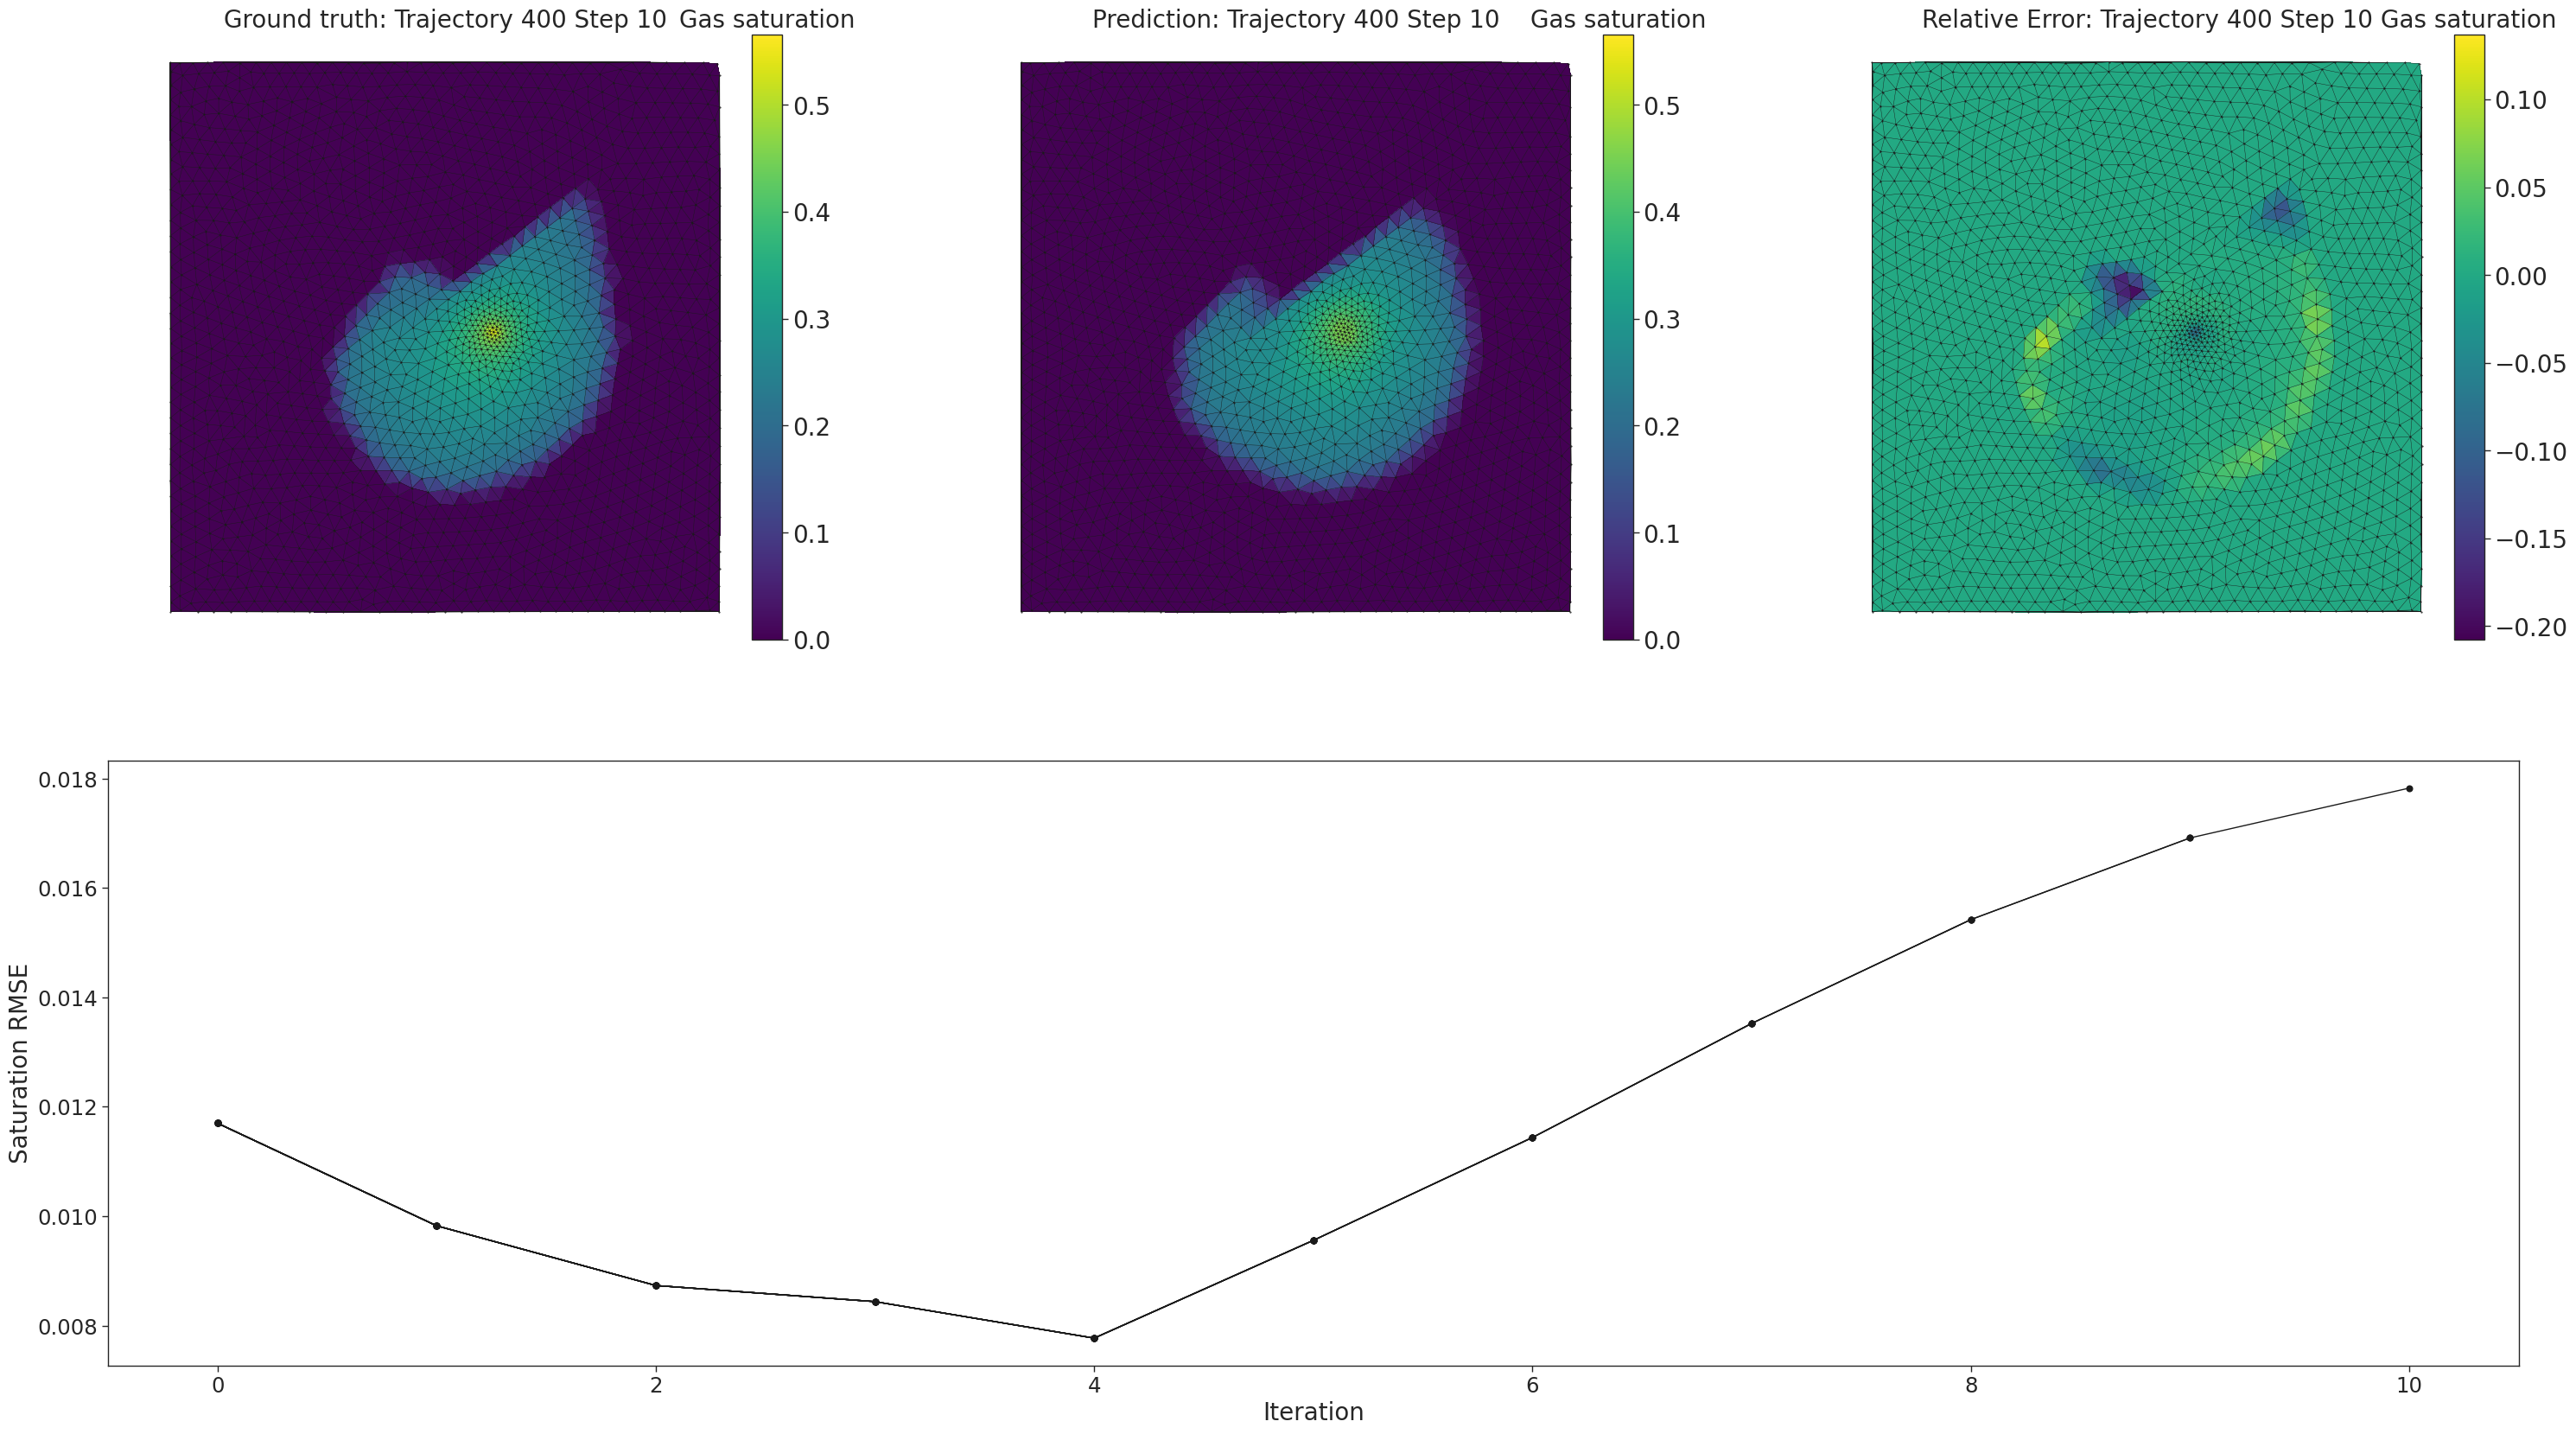

In [20]:
# visualize predicted saturation with rolling out 50 timesteps
mesh_num = 400
dataset = torch.load(file_path)[mesh_num: mesh_num + 1] # traj 0

animation_name = args.anim_name
args.postprocess_dir = postprocess_dir
eval_data_loader, mesh0_rmse, mesh0_rela_error = visualize(dataset, model, args.postprocess_dir, args, animation_name, stats_list, comp_args,
                                         make_movie = True, rolling_out=True, traj_num= mesh_num,
                                         skip = 1, plot_rmse = True, save_vtk = False)

In [21]:
np.mean(mesh0_rmse)

0.011922806

## Unseen mesh

Generating Mesh490_sg_mgn_lstm_trained fields...
11


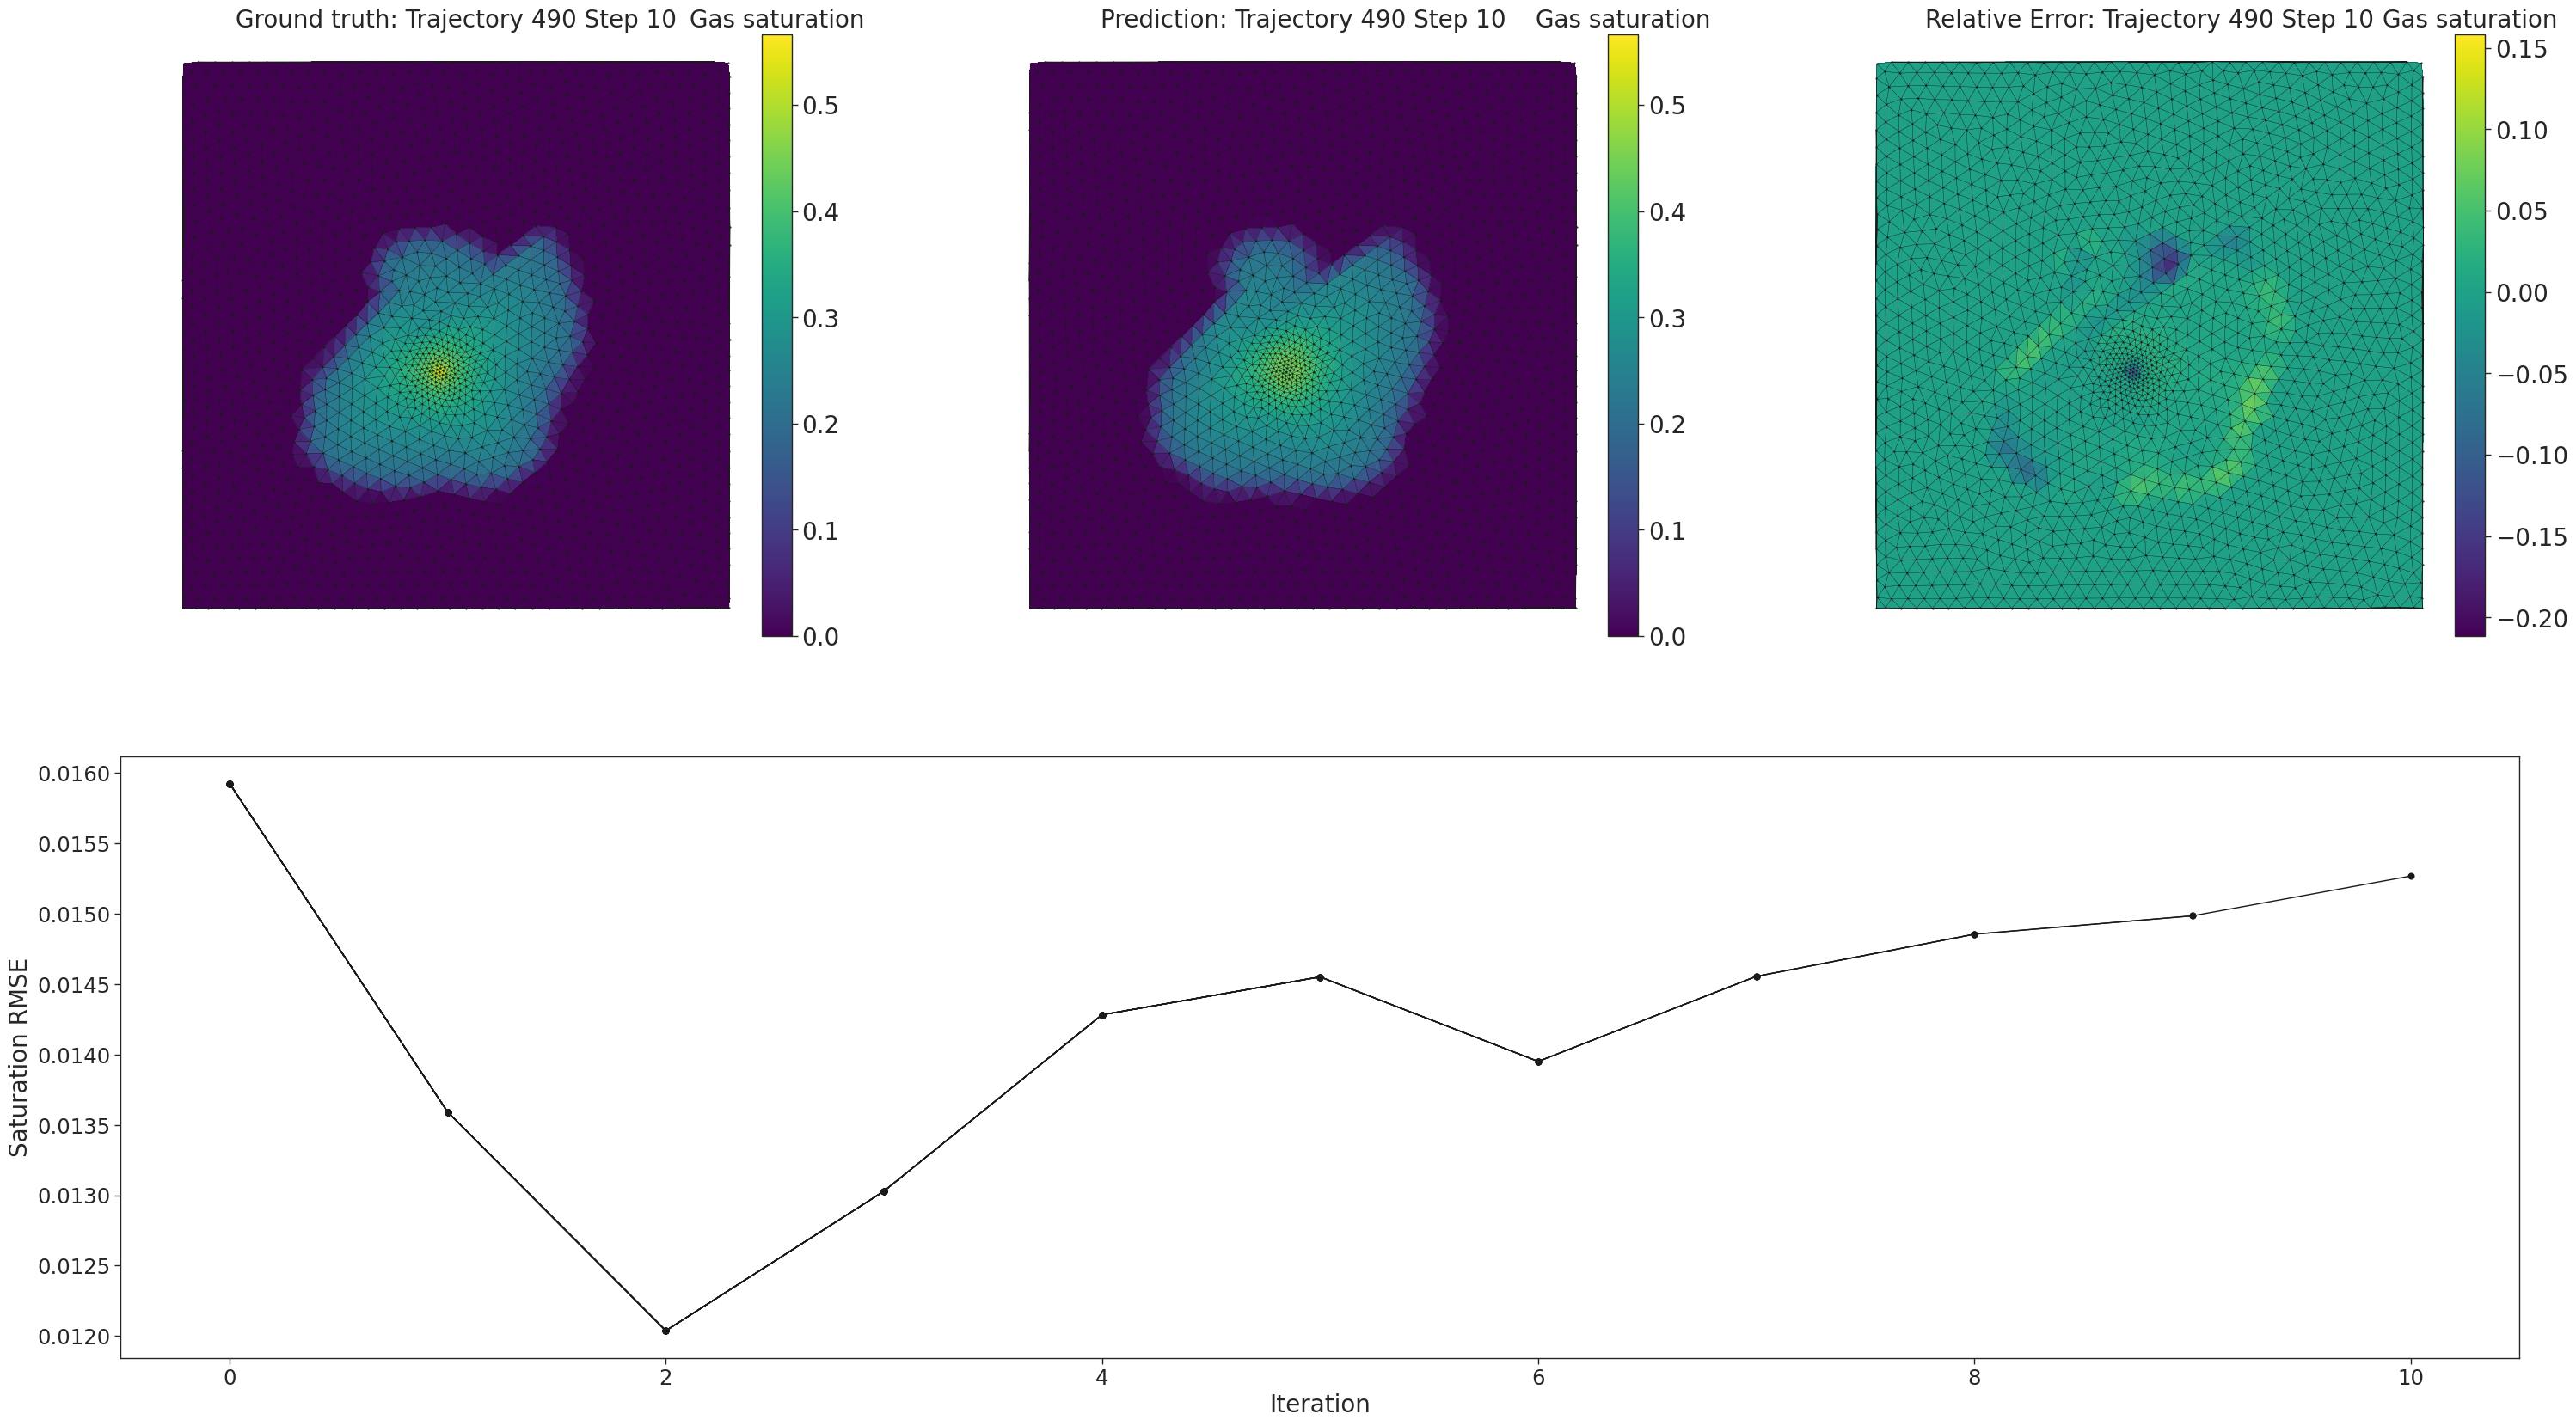

In [23]:
# visualize predicted saturation with rolling out 50 timesteps
mesh_num = 490
dataset = torch.load(file_path)[mesh_num: mesh_num + 1] # traj 0

animation_name = args.anim_name
args.postprocess_dir = postprocess_dir
eval_data_loader, mesh0_rmse, mesh0_rela_error = visualize(dataset, model, args.postprocess_dir, args, animation_name, stats_list, comp_args,
                                         make_movie = True, rolling_out=True, traj_num= mesh_num,
                                         skip = 1, plot_rmse = True, save_vtk = False)

In [24]:
np.mean(mesh0_rmse)

0.01427572